<a href="https://colab.research.google.com/github/mannodiarun/perovs_dft_ml/blob/main/Perovs_DFT_ML_MRS_tutorial_reduced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This project uses high-throughput density functional theory (DFT) data on halide perovskite alloys to train predictive machine learning (ML) models using a variety of regression algorithms for properties of interest and perform multi-objective inverse design using genetic algorithm (GA).

# DFT calculations are performed at two levels of theory: GGA-PBE (494 data points, referred to as PBE henceforth) and HSE06 (244 data points, referred to as HSE henceforth). DFT data can be read from the Data.xlsx file. Three properties are computed: the decomposition energy (in eV per formula unit), the band gap (in eV), and the spectroscopic limited maximum efficiency (SLME, in fraction, indicating a theoretical limit for photovoltaic power conversion efficiency). Every data point or compound is identified using an Index and a Formula. Two types of input descriptors are defined (to be used for training input -> output predictive models): a composition vector (14 dim) and a elemental properties vector (36 dim). The data is split in 3 sheets: PBE only, HSE only, and PBE+HSE (which combines the two data types using a one-hot encoded vector as additional descriptor to identiy data type).

# This notebook calls relevant python packages, reads the DFT data, performs some visualization, and then has different sections for a variety of ML treatments including principal component analysis (PCA), elasticnet regression, random forest regression, kernel ridge regression, and genetic algorithm.

# To learn more, contact Arun Mannodi Kanakkithodi (amannodi@purdue.edu), Jiaqi Yang (yang1494@purdue.edu), or Panayotis Manganaris (pmangana@purdue.edu). Other resources related to this project: https://github.com/mannodiarun/perovs_dft_ml, nanohub.org/tools/mrsicmsnotes/.

---



# The overall goal of this project is to learn from a multi-fidelity DFT dataset (properties computed from different PBE and HSE functionals) of halide perovskite alloys in different cubic and non-cubic phases, and obtain predictive models for multiple properties at different fidelities. Best models are subsequently used for large-scale prediction and inverse design. This current notebook contains only the cubic data from two types of functionals.

# The main part of the tutorial begins here.

In [ ]:
import numpy as np     
import csv 
import copy 
import random
import pandas as pd
import matplotlib.pyplot as plt 
import scipy
from scipy import stats
from sklearn.preprocessing import normalize
from pandas import read_csv
import sklearn
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared

# from geneticalgorithm2 import geneticalgorithm2 as ga # for creating and running optimization model
# from geneticalgorithm2 import Crossover, Mutations, Selection # classes for specific mutation and crossover behavior
# from geneticalgorithm2 import Population_initializer # for creating better start population
# from geneticalgorithm2 import np_lru_cache # for cache function (if u want)
# from geneticalgorithm2 import plot_pop_scores # for plotting population scores, if u want
# from geneticalgorithm2 import Callbacks # simple callbacks
# from geneticalgorithm2 import Actions, ActionConditions, MiddleCallbacks # middle callbacks

import warnings
warnings.filterwarnings("ignore")


In [ ]:
###  Read Data  ###


##  Choose Dataset Type  ##
Data = 'PBE'
#Data = 'HSE'
#Data = 'PBE_and_HSE'

##  Choose Descriptor Type  ##
#Desc = 'Composition Only'
#Desc = 'Elemental Only'
Desc = 'Composition and Elemental'


if Data == 'PBE':
    !wget https://raw.githubusercontent.com/mannodiarun/perovs_dft_ml/main/PBE_data.csv
    D = read_csv('PBE_data.csv')
    df = pd.DataFrame(D)
    Index = df.Index
    Formula = df.Formula
    Decomp = df.Decomp
    Gap = df.Gap
    SLME = df.SLME
    Comp_desc = pd.DataFrame(D, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I'])
    Elem_desc = pd.DataFrame(D, columns=['A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])
    All_desc = pd.DataFrame(D, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])
    
    
if Data == 'HSE':
    !wget https://raw.githubusercontent.com/mannodiarun/perovs_dft_ml/main/HSE_data.csv
    D = read_csv('HSE_data.csv')
    df = pd.DataFrame(D)
    Index = df.Index
    Formula = df.Formula
    Decomp = df.Decomp
    Gap = df.Gap
    SLME = df.SLME
    Comp_desc = pd.DataFrame(D, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I'])
    Elem_desc = pd.DataFrame(D, columns=['A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])
    All_desc = pd.DataFrame(D, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])
    
    
if Data == 'PBE_and_HSE':
    !wget https://raw.githubusercontent.com/mannodiarun/perovs_dft_ml/main/PBE_and_HSE_data.csv
    D = read_csv('PBE_and_HSE_data.csv')
    df = pd.DataFrame(D)
    Index = df.Index
    Formula = df.Formula
    Decomp = df.Decomp
    Gap = df.Gap
    SLME = df.SLME
    Comp_desc = pd.DataFrame(D, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'PBE', 'HSE'])
    Elem_desc = pd.DataFrame(D, columns=['PBE', 'HSE', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])
    All_desc = pd.DataFrame(D, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'PBE', 'HSE', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])


if Desc == 'Composition Only':
    X = copy.deepcopy(Comp_desc)
if Desc == 'Elemental Only':
    X = copy.deepcopy(Elem_desc)
if Desc == 'Composition and Elemental':
    X = copy.deepcopy(All_desc)
    
n = Index.size
m = int(X.size/n)

X_norm = normalize(X, norm='l2', axis=0)
X = copy.deepcopy(X_norm)
X_fl = np.array(X, dtype="float32")


--2022-11-27 00:21:05--  https://raw.githubusercontent.com/mannodiarun/perovs_dft_ml/main/PBE_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 242860 (237K) [text/plain]
Saving to: ‘PBE_data.csv.4’

PBE_data.csv.4      100%[===================>] 237.17K  --.-KB/s    in 0.004s  

2022-11-27 00:21:05 (64.7 MB/s) - ‘PBE_data.csv.4’ saved [242860/242860]



In [ ]:
df

,Index,Formula,Decomp,Gap,SLME,K,Rb,Cs,MA,FA,...,X_MP,X_dens,X_at_wt,X_EA,X_IE,X_hof,X_hov,X_En,X_at_num,X_period
0,1,MAGeCl_3,-0.39,1.95,0.15,0.0,0.0,0.0,1.0,0.0,...,172.0,3.21,35.5,349.0,1250.0,3.21,10.2,3.16,17.0,3.00
1,2,MAGeBr_3,-0.24,1.61,0.20,0.0,0.0,0.0,1.0,0.0,...,266.0,3.12,79.9,325.0,1140.0,5.29,14.7,2.96,35.0,4.00
2,3,MAGeI_3,-0.03,1.31,0.23,0.0,0.0,0.0,1.0,0.0,...,387.0,4.93,127.0,295.0,1010.0,7.76,20.9,2.66,53.0,5.00
3,4,MASnCl_3,-0.25,1.58,0.17,0.0,0.0,0.0,1.0,0.0,...,172.0,3.21,35.5,349.0,1250.0,3.21,10.2,3.16,17.0,3.00
4,5,MASnBr_3,-0.23,1.26,0.20,0.0,0.0,0.0,1.0,0.0,...,266.0,3.12,79.9,325.0,1140.0,5.29,14.7,2.96,35.0,4.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489,495,FAGeI_1.125_Cl_1.875,-0.99,2.16,0.11,0.0,0.0,0.0,0.0,1.0,...,253.0,3.86,69.7,329.0,1160.0,4.92,14.2,2.97,30.5,3.75
490,496,FASnI_0.375_Cl_2.625,-1.06,2.58,0.06,0.0,0.0,0.0,0.0,1.0,...,199.0,3.43,46.9,342.0,1220.0,3.78,11.5,3.10,21.5,3.25
491,497,MAPbCl_1.125_I_1.875,0.08,1.87,0.16,0.0,0.0,0.0,1.0,0.0,...,306.0,4.29,92.6,315.0,1100.0,6.05,16.9,2.85,39.5,4.25
492,498,MASrCl_0.75_I_2.25,0.18,3.69,0.00,0.0,0.0,0.0,1.0,0.0,...,333.0,4.50,104.0,309.0,1070.0,6.62,18.2,2.79,44.0,4.50


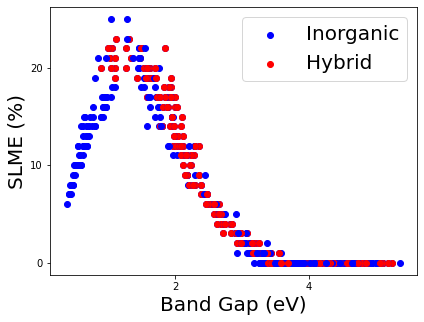

In [ ]:
###   Data Visualization    ###

fig = plt.subplots( figsize=(6,6) )
plt.subplots_adjust(left=0.11, bottom=0.24, right=0.96, top=0.86, wspace=0.30, hspace=0.40)
plt.rc('font', family='Arial narrow')
prop1 = Gap
prop2 = SLME*100

for i in range(0,n):
    plt.scatter(prop1[i] , prop2[i], c='b', label='_nolegend_')
    if df.MA[i] > 0.0 or df.FA[i] > 0.0:
        plt.scatter(prop1[i] , prop2[i], c='r', label='_nolegend_')
plt.scatter(prop1[0], prop2[0], c='b', label='Inorganic')
plt.scatter(prop1[0], prop2[0], c='r', label='Hybrid')
plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)
plt.xlabel('Band Gap (eV)', c='k', fontsize=20)
plt.ylabel('SLME (%)', c='k', fontsize=20)
plt.legend(loc='upper right', ncol=1, frameon=True, prop={'family':'Arial narrow','size':20})



# Techniques such as principal component analysis (PCA) can be used to perform dimensionality reduction and clustering on the halide perovskite dataset, using compositional information and/or elemental properties as input.

[1.75380550e-01 1.49175460e-01 1.16849818e-01 9.92793617e-02
 8.18570803e-02 6.90395707e-02 6.85492400e-02 6.44622470e-02
 6.15506781e-02 5.90112080e-02 5.48434155e-02 1.69271825e-07
 1.38171652e-07 1.34765297e-07 1.21334922e-07 9.81331876e-08
 7.55792674e-08 7.14854208e-08 6.96121296e-08 5.37321141e-08
 4.55402138e-08 4.36943364e-08 4.28182062e-08 3.69749362e-08
 3.41906404e-08 3.12917250e-08 2.70597465e-08 2.33100155e-08
 2.00255009e-08 1.87997610e-08 1.60581748e-08 1.54559030e-08
 1.43722875e-08 1.10757322e-08 7.97775148e-09 7.39011792e-09
 6.35624125e-09 5.72114492e-09 5.34438842e-09 5.00115421e-09
 4.07022933e-09 3.63561965e-09 3.48717918e-09 3.41786122e-09
 2.75919856e-09 2.56224285e-09 3.76327974e-11 4.11451733e-32
 1.21899412e-32 8.96434754e-33]
[1.63132106e+00 1.50451812e+00 1.33156616e+00 1.22737767e+00
 1.11449174e+00 1.02352339e+00 1.01988229e+00 9.89011746e-01
 9.66418312e-01 9.46271984e-01 9.12243917e-01 1.60265878e-03
 1.44796547e-03 1.43000569e-03 1.35688061e-03 1.22027

Text(0, 0.5, 'PC2')

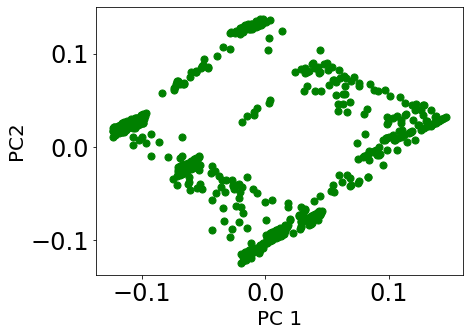

In [ ]:
###   Dimensionality Reduction: Principal Component Analysis (PCA)    ###


pca = PCA(svd_solver='full')
#pca = PCA(n_components=1, svd_solver='arpack')

pca.fit(X)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)


fig = plt.subplots( figsize=(6,6) )
plt.subplots_adjust(left=0.11, bottom=0.24, right=0.96, top=0.86, wspace=0.30, hspace=0.40)
plt.rc('font', family='Arial narrow')

# x = np.arange(0,m)
# plt.bar(x[:], pca.explained_variance_ratio_[:], color ='r', width = 0.9, edgecolor ='grey', align='center')
# plt.rc('xtick', labelsize=24)
# plt.rc('ytick', labelsize=24)
# plt.xlabel('PC Number', c='k', fontsize=20)
# plt.ylabel('Explained Variance', c='k', fontsize=20)

X_p = pca.transform(X)
plt.scatter(X_p[:,0], X_p[:,1], c='g', marker='o', s=50)
plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)
plt.xlabel('PC 1', c='k', fontsize=20)
plt.ylabel('PC2', c='k', fontsize=20)


In [ ]:
X

array([[0.        , 0.        , 0.        , ..., 0.04866256, 0.01992393,
        0.03278789],
       [0.        , 0.        , 0.        , ..., 0.04558265, 0.04101985,
        0.04371718],
       [0.        , 0.        , 0.        , ..., 0.04096279, 0.06211578,
        0.05464648],
       ...,
       [0.        , 0.        , 0.        , ..., 0.0438887 , 0.04629384,
        0.04644951],
       [0.        , 0.        , 0.        , ..., 0.04296473, 0.05156782,
        0.04918183],
       [0.        , 0.        , 0.        , ..., 0.04481267, 0.04101985,
        0.04371718]])

# Qualitative insights can be attained by determining linear correlation between descriptors and properties.

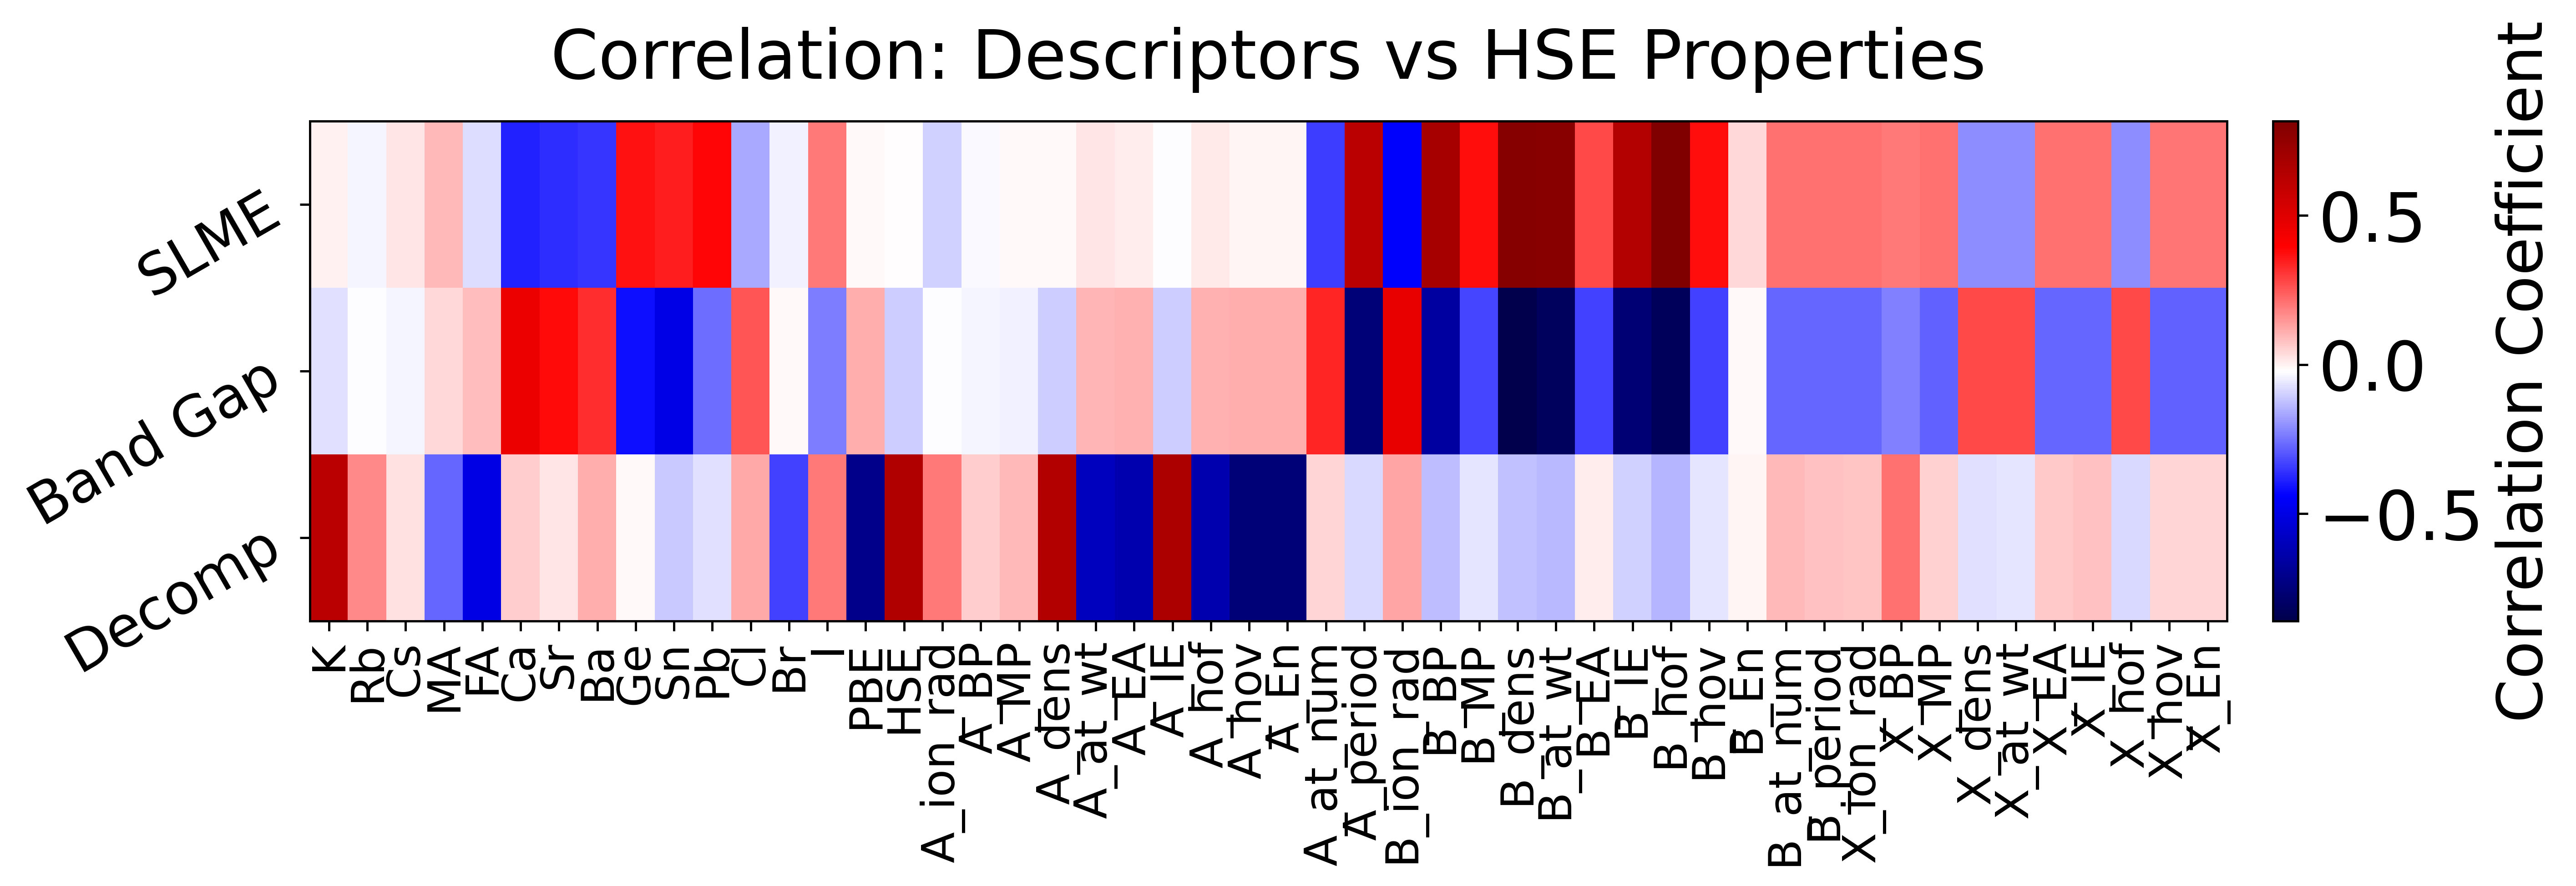

In [ ]:
###   Pearson Coefficient of Linear Correlation    ###


Corr = [[0.0 for a in range(m)] for b in range(3)]

for i in range(0,m):
    x = stats.pearsonr(X_fl[:,i], Decomp[:])
    Corr[0][i] = x[0]
    x = stats.pearsonr(X_fl[:,i], Gap[:])
    Corr[1][i] = x[0]
    x = stats.pearsonr(X_fl[:,i], SLME[:])
    Corr[2][i] = x[0]

    
x = np.arange(m)
xx = [0.0]*m
for i in range(0,m):
    xx[i] = x[i]+0.5
y = [0.5,1.5,2.5]
f = 16
r = 75
Prop = ['Decomp', 'Band Gap', 'SLME']


scale = ['linear']
plotposition = [131, 132, 133]

fig=plt.figure(figsize=(12,4),dpi=450)
plt.rcParams.update({'font.size': 16})
plt.rc('font', family='Arial narrow')
plt.subplots_adjust(left=0.10, right=1.04, top=0.85, bottom=0.24, wspace=0.2, hspace=0.2)

ax = plt.plot(plotposition[0])
plt.plot(plotposition[0])
plt.xscale(scale[0])
plt.yscale(scale[0])
plt.xlim([0,m])
plt.ylim([0,3])

#Labels = ['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I']
#Labels = ['A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period']
#Labels = ['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period']

#Labels = ['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'PBE', 'HSE']
#Labels = ['PBE', 'HSE', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period']
Labels = ['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'PBE', 'HSE', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period']


plt.xticks(xx[0:m], Labels[0:m], rotation=90, fontsize=16)

plt.yticks(y[:], Prop[:], rotation=30, fontsize=20)
plt.title('Correlation: Descriptors vs HSE Properties', fontname='Arial narrow', size=24, horizontalalignment='center', pad=15)
plt.pcolor(Corr, cmap='seismic')
cbar = plt.colorbar(orientation="vertical", pad=0.02)
cbar.set_label(label='Correlation Coefficient', size=22)
#plt.savefig('corr_hse.pdf', dpi=450)



# Split dataset into training and test sets for regression models.

In [ ]:
###  Training-Test Split  ###

t = 0.20

X_train, X_test, Prop_decomp_train, Prop_decomp_test, Prop_gap_train, Prop_gap_test, Prop_slme_train, Prop_slme_test = train_test_split(X, Decomp, Gap, SLME, test_size=t)

n_tr = Prop_gap_train.size
n_te = Prop_gap_test.size

X_train_fl = np.array(X_train, dtype="float32")
Prop_decomp_train_fl = np.array(Prop_decomp_train, dtype="float32")
Prop_gap_train_fl = np.array(Prop_gap_train, dtype="float32")
Prop_slme_train_fl = np.array(Prop_slme_train, dtype="float32")

X_test_fl = np.array(X_test, dtype="float32")
Prop_decomp_test_fl = np.array(Prop_decomp_test, dtype="float32")
Prop_gap_test_fl = np.array(Prop_gap_test, dtype="float32")
Prop_slme_test_fl = np.array(Prop_slme_test, dtype="float32")



# The cells below train linear (elastic net), random forest, and kernel ridge regression models, including hyperparameter optimization and cross-validation.

In [ ]:
###  Define Elastic Net Regression Hyperparameter Space  ###


param_grid = {
"alpha": [1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
"max_iter": [1e3, 1e4],
#"tol": [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
"tol": [1e-1]
}

#  Train Model For Decomposition Energy ##

elast_decomp = GridSearchCV(ElasticNet(), param_grid=param_grid, cv=5)

elast_decomp.fit(X_train_fl, Prop_decomp_train_fl)
Pred_train = elast_decomp.predict(X_train_fl)
Pred_test = elast_decomp.predict(X_test_fl)

Pred_decomp_train_fl = np.array(Pred_train, dtype="float32")
Pred_decomp_test_fl = np.array(Pred_test, dtype="float32")

rmse_test_decomp = np.sqrt( sklearn.metrics.mean_squared_error(Prop_decomp_test_fl, Pred_decomp_test_fl) )
rmse_train_decomp = np.sqrt( sklearn.metrics.mean_squared_error(Prop_decomp_train_fl, Pred_decomp_train_fl) )
print('rmse_test_decomp = ', rmse_test_decomp)
print('rmse_train_decomp = ', rmse_train_decomp)


#  Train Model For Band Gap ##

elast_gap = GridSearchCV(ElasticNet(), param_grid=param_grid, cv=5)

elast_gap.fit(X_train_fl, Prop_gap_train_fl)
Pred_train = elast_gap.predict(X_train_fl)
Pred_test = elast_gap.predict(X_test_fl)

Pred_gap_train_fl = np.array(Pred_train, dtype="float32")
Pred_gap_test_fl = np.array(Pred_test, dtype="float32")

rmse_test_gap = np.sqrt( sklearn.metrics.mean_squared_error(Prop_gap_test_fl, Pred_gap_test_fl) )
rmse_train_gap = np.sqrt( sklearn.metrics.mean_squared_error(Prop_gap_train_fl, Pred_gap_train_fl) )
print('rmse_test_gap = ', rmse_test_gap)
print('rmse_train_gap = ', rmse_train_gap)


#  Train Model For PV SLME ##

elast_slme = GridSearchCV(ElasticNet(), param_grid=param_grid, cv=5)

elast_slme.fit(X_train_fl, Prop_slme_train_fl)
Pred_train = elast_slme.predict(X_train_fl)
Pred_test = elast_slme.predict(X_test_fl)

Pred_slme_train_fl = np.array(Pred_train, dtype="float32")
Pred_slme_test_fl = np.array(Pred_test, dtype="float32")

rmse_test_slme = np.sqrt( sklearn.metrics.mean_squared_error(Prop_slme_test_fl, Pred_slme_test_fl) )
rmse_train_slme = np.sqrt( sklearn.metrics.mean_squared_error(Prop_slme_train_fl, Pred_slme_train_fl) )
print('rmse_test_slme = ', rmse_test_slme)
print('rmse_train_slme = ', rmse_train_slme)



rmse_test_decomp =  0.53446066
rmse_train_decomp =  0.60656047
rmse_test_gap =  0.37558433
rmse_train_gap =  0.38328874
rmse_test_slme =  0.039406393
rmse_train_slme =  0.038608655


In [ ]:
###  Define Random Forest Hyperparameter Space  ###

param_grid = {
"n_estimators": [100, 200, 500],
"max_features": [6, 10, m],
"min_samples_leaf": [5,10,20],
"max_depth": [5,10,15],
"min_samples_split": [2, 5, 10]
}

param_grid = { "n_estimators": [100, 200], "max_depth": [10,15], "min_samples_split": [5, 10] }



#  Train Model For Decomposition Energy ##

rfr_decomp = GridSearchCV(RandomForestRegressor(), param_grid=param_grid, cv=5)

rfr_decomp.fit(X_train_fl, Prop_decomp_train_fl)
Pred_train = rfr_decomp.predict(X_train_fl)
Pred_test = rfr_decomp.predict(X_test_fl)
#Pred_out = rfr_decomp.predict(X_out_fl)

Pred_decomp_train_fl = np.array(Pred_train, dtype="float32")
Pred_decomp_test_fl = np.array(Pred_test, dtype="float32")
#Pred_decomp_out_fl = np.array(Pred_out, dtype="float32")

rmse_test_decomp = np.sqrt( sklearn.metrics.mean_squared_error(Prop_decomp_test_fl, Pred_decomp_test_fl) )
rmse_train_decomp = np.sqrt( sklearn.metrics.mean_squared_error(Prop_decomp_train_fl, Pred_decomp_train_fl) )
print('rmse_test_decomp = ', rmse_test_decomp)
print('rmse_train_decomp = ', rmse_train_decomp)


#  Train Model For Band Gap ##

rfr_gap = GridSearchCV(RandomForestRegressor(), param_grid=param_grid, cv=5)

rfr_gap.fit(X_train_fl, Prop_gap_train_fl)
Pred_train = rfr_gap.predict(X_train_fl)
Pred_test = rfr_gap.predict(X_test_fl)
#Pred_out = rfr_gap.predict(X_out_fl)

Pred_gap_train_fl = np.array(Pred_train, dtype="float32")
Pred_gap_test_fl = np.array(Pred_test, dtype="float32")
#Pred_gap_out_fl = np.array(Pred_out, dtype="float32")

rmse_test_gap = np.sqrt( sklearn.metrics.mean_squared_error(Prop_gap_test_fl, Pred_gap_test_fl) )
rmse_train_gap = np.sqrt( sklearn.metrics.mean_squared_error(Prop_gap_train_fl, Pred_gap_train_fl) )
print('rmse_test_gap = ', rmse_test_gap)
print('rmse_train_gap = ', rmse_train_gap)


#  Train Model For PV SLME ##

rfr_slme = GridSearchCV(RandomForestRegressor(), param_grid=param_grid, cv=5)

rfr_slme.fit(X_train_fl, Prop_slme_train_fl)
Pred_train = rfr_slme.predict(X_train_fl)
Pred_test = rfr_slme.predict(X_test_fl)
#Pred_out = rfr_slme.predict(X_out_fl)

Pred_slme_train_fl = np.array(Pred_train, dtype="float32")
Pred_slme_test_fl = np.array(Pred_test, dtype="float32")
#Pred_slme_out_fl = np.array(Pred_out, dtype="float32")

rmse_test_slme = np.sqrt( sklearn.metrics.mean_squared_error(Prop_slme_test_fl, Pred_slme_test_fl) )
rmse_train_slme = np.sqrt( sklearn.metrics.mean_squared_error(Prop_slme_train_fl, Pred_slme_train_fl) )
print('rmse_test_slme = ', rmse_test_slme)
print('rmse_train_slme = ', rmse_train_slme)



rmse_test_decomp =  0.2445757
rmse_train_decomp =  0.10878259
rmse_test_gap =  0.22095525
rmse_train_gap =  0.16025168
rmse_test_slme =  0.020761384
rmse_train_slme =  0.014232156


In [ ]:
###  Define Kernel Ridge Regression Hyperparameter Space  ###

param_grid = {
#"alpha": [1e0, 1e-1, 1e-2, 1e-3],
#"alpha": [10],
"kernel": [ExpSineSquared(l, p)
            for l in np.logspace(-2, 2, 10)
            for p in np.logspace(0, 2, 10)]
}


#  Train Model For Decomposition Energy ##

krr_decomp = GridSearchCV(KernelRidge(), param_grid=param_grid, cv=5)

krr_decomp.fit(X_train_fl, Prop_decomp_train_fl)
Pred_train = krr_decomp.predict(X_train_fl)
Pred_test = krr_decomp.predict(X_test_fl)
#Pred_out = krr_decomp.predict(X_out_fl)

Pred_decomp_train_fl = np.array(Pred_train, dtype="float32")
Pred_decomp_test_fl = np.array(Pred_test, dtype="float32")
#Pred_decomp_out_fl = np.array(Pred_out, dtype="float32")

rmse_test_decomp = np.sqrt( sklearn.metrics.mean_squared_error(Prop_decomp_test_fl, Pred_decomp_test_fl) )
rmse_train_decomp = np.sqrt( sklearn.metrics.mean_squared_error(Prop_decomp_train_fl, Pred_decomp_train_fl) )
print('rmse_test_decomp = ', rmse_test_decomp)
print('rmse_train_decomp = ', rmse_train_decomp)


#  Train Model For Band Gap ##

krr_gap = GridSearchCV(KernelRidge(), param_grid=param_grid, cv=5)

krr_gap.fit(X_train_fl, Prop_gap_train_fl)
Pred_train = krr_gap.predict(X_train_fl)
Pred_test = krr_gap.predict(X_test_fl)
#Pred_out = krr_gap.predict(X_out_fl)

Pred_gap_train_fl = np.array(Pred_train, dtype="float32")
Pred_gap_test_fl = np.array(Pred_test, dtype="float32")
#Pred_gap_out_fl = np.array(Pred_out, dtype="float32")

rmse_test_gap = np.sqrt( sklearn.metrics.mean_squared_error(Prop_gap_test_fl, Pred_gap_test_fl) )
rmse_train_gap = np.sqrt( sklearn.metrics.mean_squared_error(Prop_gap_train_fl, Pred_gap_train_fl) )
print('rmse_test_gap = ', rmse_test_gap)
print('rmse_train_gap = ', rmse_train_gap)


#  Train Model For PV SLME ##

krr_slme = GridSearchCV(KernelRidge(), param_grid=param_grid, cv=5)

krr_slme.fit(X_train_fl, Prop_slme_train_fl)
Pred_train = krr_slme.predict(X_train_fl)
Pred_test = krr_slme.predict(X_test_fl)
#Pred_out = krr_slme.predict(X_out_fl)

Pred_slme_train_fl = np.array(Pred_train, dtype="float32")
Pred_slme_test_fl = np.array(Pred_test, dtype="float32")
#Pred_slme_out_fl = np.array(Pred_out, dtype="float32")

rmse_test_slme = np.sqrt( sklearn.metrics.mean_squared_error(Prop_slme_test_fl, Pred_slme_test_fl) )
rmse_train_slme = np.sqrt( sklearn.metrics.mean_squared_error(Prop_slme_train_fl, Pred_slme_train_fl) )
print('rmse_test_slme = ', rmse_test_slme)
print('rmse_train_slme = ', rmse_train_slme)



rmse_test_decomp =  0.27016103
rmse_train_decomp =  0.26744643
rmse_test_gap =  0.41820678
rmse_train_gap =  0.41327357
rmse_test_slme =  0.028302962
rmse_train_slme =  0.030548926


# Visualize the performance of predictive models using parity plots below.

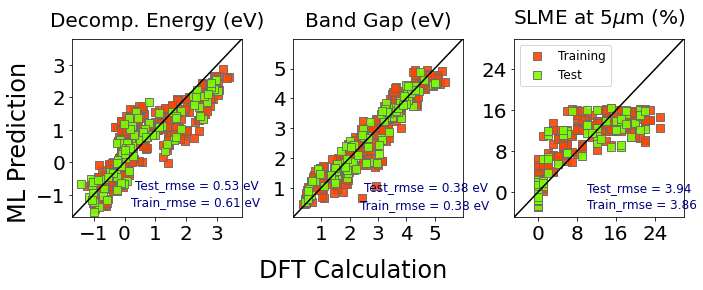

In [ ]:
#  ML Parity Plots ##

if Data == 'PBE':

    fig, ( [ax1, ax2, ax3] ) = plt.subplots( nrows=1, ncols=3, figsize=(10,4) )
    fig.text(0.5, 0.03, 'DFT Calculation', ha='center', fontsize=24)
    fig.text(0.02, 0.5, 'ML Prediction', va='center', rotation='vertical', fontsize=24)
    plt.subplots_adjust(left=0.11, bottom=0.24, right=0.96, top=0.86, wspace=0.30, hspace=0.40)
    plt.rc('font', family='Arial narrow')
    a = [-175,0,125]
    b = [-175,0,125]

    Prop_train_temp = copy.deepcopy(Prop_decomp_train_fl)
    Pred_train_temp = copy.deepcopy(Pred_decomp_train_fl)
    Prop_test_temp  = copy.deepcopy(Prop_decomp_test_fl)
    Pred_test_temp  = copy.deepcopy(Pred_decomp_test_fl)
    ax1.plot(b, a, c='k', ls='-')
    ax1.xaxis.set_tick_params(labelsize=20)
    ax1.yaxis.set_tick_params(labelsize=20)
    ax1.scatter(Prop_train_temp[:], Pred_train_temp[:], c='orangered', marker='s', s=60, edgecolors='dimgrey', alpha=0.9, label='Training')
    ax1.scatter(Prop_test_temp[:], Pred_test_temp[:], c='lawngreen', marker='s', s=60, edgecolors='dimgrey', alpha=0.9, label='Test')
    te = '%.2f' % rmse_test_decomp
    tr = '%.2f' % rmse_train_decomp
    ax1.text(0.35, -0.80, 'Test_rmse = ' + te + ' eV', c='navy', fontsize=12)
    ax1.text(0.22, -1.35, 'Train_rmse = ' + tr + ' eV', c='navy', fontsize=12)
    ax1.set_ylim([-1.7, 3.8])
    ax1.set_xlim([-1.7, 3.8])
    ax1.set_xticks([-1.0, 0.0, 1.0, 2.0, 3.0])
    ax1.set_yticks([-1.0, 0.0, 1.0, 2.0, 3.0])
    ax1.set_title('Decomp. Energy (eV)', c='k', fontsize=20, pad=12)
    #ax1.legend(loc='upper left',ncol=1, frameon=True, prop={'family':'Arial narrow','size':12})

    Prop_train_temp = copy.deepcopy(Prop_gap_train_fl)
    Pred_train_temp = copy.deepcopy(Pred_gap_train_fl)
    Prop_test_temp  = copy.deepcopy(Prop_gap_test_fl)
    Pred_test_temp  = copy.deepcopy(Pred_gap_test_fl)
    ax2.plot(b, a, c='k', ls='-')
    ax2.xaxis.set_tick_params(labelsize=20)
    ax2.yaxis.set_tick_params(labelsize=20)
    ax2.scatter(Prop_train_temp[:], Pred_train_temp[:], c='orangered', marker='s', s=60, edgecolors='dimgrey', alpha=0.9, label='Training')
    ax2.scatter(Prop_test_temp[:], Pred_test_temp[:], c='lawngreen', marker='s', s=60, edgecolors='dimgrey', alpha=0.9, label='Test')
    te = '%.2f' % rmse_test_gap
    tr = '%.2f' % rmse_train_gap
    ax2.text(2.50, 0.9, 'Test_rmse = ' + te + ' eV', c='navy', fontsize=12)
    ax2.text(2.36, 0.3, 'Train_rmse = ' + tr + ' eV', c='navy', fontsize=12)
    ax2.set_ylim([0.0, 6.0])
    ax2.set_xlim([0.0, 6.0])
    ax2.set_xticks([1, 2, 3, 4, 5])
    ax2.set_yticks([1, 2, 3, 4, 5])
    ax2.set_title('Band Gap (eV)', c='k', fontsize=20, pad=12)
    #ax2.legend(loc='upper left',ncol=1, frameon=True, prop={'family':'Arial narrow','size':12})

    Prop_train_temp = copy.deepcopy(Prop_slme_train_fl*100)
    Pred_train_temp = copy.deepcopy(Pred_slme_train_fl*100)
    Prop_test_temp  = copy.deepcopy(Prop_slme_test_fl*100)
    Pred_test_temp  = copy.deepcopy(Pred_slme_test_fl*100)
    ax3.plot(b, a, c='k', ls='-')
    ax3.xaxis.set_tick_params(labelsize=20)
    ax3.yaxis.set_tick_params(labelsize=20)
    ax3.scatter(Prop_train_temp[:], Pred_train_temp[:], c='orangered', marker='s', s=60, edgecolors='dimgrey', alpha=0.9, label='Training')
    ax3.scatter(Prop_test_temp[:], Pred_test_temp[:], c='lawngreen', marker='s', s=60, edgecolors='dimgrey', alpha=0.9, label='Test')
    te = '%.2f' % (rmse_test_slme*100)
    tr = '%.2f' % (rmse_train_slme*100)
    ax3.text(10, 0, 'Test_rmse = ' + te, c='navy', fontsize=12)
    ax3.text(10, -3, 'Train_rmse = ' + tr, c='navy', fontsize=12)
    ax3.set_ylim([-5, 30])
    ax3.set_xlim([-5, 30])
    ax3.set_xticks([0, 8, 16, 24])
    ax3.set_yticks([0, 8, 16, 24])
    ax3.set_title('SLME at 5$\mu$m (%)', fontsize=20, pad=15)
    ax3.legend(loc='upper left', ncol=1, frameon=True, prop={'family':'Arial narrow','size':12})
 
#    plt.savefig('plot_PBE.pdf', dpi=450)



if Data == 'HSE':

    fig, ( [ax1, ax2, ax3] ) = plt.subplots( nrows=1, ncols=3, figsize=(10,4) )
    fig.text(0.5, 0.03, 'DFT Calculation', ha='center', fontsize=24)
    fig.text(0.02, 0.5, 'ML Prediction', va='center', rotation='vertical', fontsize=24)
    plt.subplots_adjust(left=0.11, bottom=0.24, right=0.96, top=0.86, wspace=0.30, hspace=0.40)
    plt.rc('font', family='Arial narrow')
    a = [-175,0,125]
    b = [-175,0,125]

    Prop_train_temp = copy.deepcopy(Prop_decomp_train_fl)
    Pred_train_temp = copy.deepcopy(Pred_decomp_train_fl)
    Prop_test_temp  = copy.deepcopy(Prop_decomp_test_fl)
    Pred_test_temp  = copy.deepcopy(Pred_decomp_test_fl)
    ax1.plot(b, a, c='k', ls='-')
    ax1.xaxis.set_tick_params(labelsize=20)
    ax1.yaxis.set_tick_params(labelsize=20)
    ax1.scatter(Prop_train_temp[:], Pred_train_temp[:], c='orangered', marker='s', s=60, edgecolors='dimgrey', alpha=0.9, label='Training')
    ax1.scatter(Prop_test_temp[:], Pred_test_temp[:], c='lawngreen', marker='s', s=60, edgecolors='dimgrey', alpha=0.9, label='Test')
    te = '%.2f' % rmse_test_decomp
    tr = '%.2f' % rmse_train_decomp
    ax1.text(0.35, -0.80, 'Test_rmse = ' + te + ' eV', c='navy', fontsize=12)
    ax1.text(0.22, -1.35, 'Train_rmse = ' + tr + ' eV', c='navy', fontsize=12)
    ax1.set_ylim([-1.7, 3.8])
    ax1.set_xlim([-1.7, 3.8])
    ax1.set_xticks([-1.0, 0.0, 1.0, 2.0, 3.0]) 
    ax1.set_yticks([-1.0, 0.0, 1.0, 2.0, 3.0])
    ax1.set_title('Decomp. Energy (eV)', c='k', fontsize=20, pad=12)
    #ax1.legend(loc='upper left',ncol=1, frameon=True, prop={'family':'Arial narrow','size':12})

    Prop_train_temp = copy.deepcopy(Prop_gap_train_fl)
    Pred_train_temp = copy.deepcopy(Pred_gap_train_fl)
    Prop_test_temp  = copy.deepcopy(Prop_gap_test_fl)
    Pred_test_temp  = copy.deepcopy(Pred_gap_test_fl)
    ax2.plot(b, a, c='k', ls='-')
    ax2.xaxis.set_tick_params(labelsize=20)
    ax2.yaxis.set_tick_params(labelsize=20)
    ax2.scatter(Prop_train_temp[:], Pred_train_temp[:], c='orangered', marker='s', s=60, edgecolors='dimgrey', alpha=0.9, label='Training')
    ax2.scatter(Prop_test_temp[:], Pred_test_temp[:], c='lawngreen', marker='s', s=60, edgecolors='dimgrey', alpha=0.9, label='Test')
    te = '%.2f' % rmse_test_gap
    tr = '%.2f' % rmse_train_gap
    ax2.text(2.70, 0.7, 'Test_rmse = ' + te + ' eV', c='navy', fontsize=12)
    ax2.text(2.55, 0.0, 'Train_rmse = ' + tr + ' eV', c='navy', fontsize=12)
    ax2.set_ylim([-0.5, 7.5])
    ax2.set_xlim([-0.5, 7.5])
    ax2.set_xticks([1.0, 3.0, 5.0, 7.0])
    ax2.set_yticks([1.0, 3.0, 5.0, 7.0])
    ax2.set_title('Band Gap (eV)', c='k', fontsize=20, pad=12)
    #ax2.legend(loc='upper left',ncol=1, frameon=True, prop={'family':'Arial narrow','size':12})

    Prop_train_temp = copy.deepcopy(Prop_slme_train_fl*100)
    Pred_train_temp = copy.deepcopy(Pred_slme_train_fl*100)
    Prop_test_temp  = copy.deepcopy(Prop_slme_test_fl*100)
    Pred_test_temp  = copy.deepcopy(Pred_slme_test_fl*100)
    ax3.plot(b, a, c='k', ls='-')
    ax3.xaxis.set_tick_params(labelsize=20)
    ax3.yaxis.set_tick_params(labelsize=20)
    ax3.scatter(Prop_train_temp[:], Pred_train_temp[:], c='orangered', marker='s', s=60, edgecolors='dimgrey', alpha=0.9, label='Training')
    ax3.scatter(Prop_test_temp[:], Pred_test_temp[:], c='lawngreen', marker='s', s=60, edgecolors='dimgrey', alpha=0.9, label='Test')
    te = '%.2f' % (rmse_test_slme*100)
    tr = '%.2f' % (rmse_train_slme*100)
    ax3.text(6, 0, 'Test_rmse = ' + te, c='navy', fontsize=12)
    ax3.text(6, -2, 'Train_rmse = ' + tr, c='navy', fontsize=12)
    ax3.set_ylim([-3, 18])
    ax3.set_xlim([-3, 18])
    ax3.set_xticks([0, 5, 10, 15])
    ax3.set_yticks([0, 5, 10, 15])
    ax3.set_title('SLME at 5$\mu$m (%)', fontsize=20, pad=15)
    ax3.legend(loc='upper left', ncol=1, frameon=True, prop={'family':'Arial narrow','size':12})

#    plt.savefig('plot_HSE.pdf', dpi=450)

    
    
if Data == 'PBE_and_HSE':

    fig, ( [ax1, ax2, ax3] ) = plt.subplots( nrows=1, ncols=3, figsize=(10,4) )
    fig.text(0.5, 0.03, 'DFT Calculation', ha='center', fontsize=24)
    fig.text(0.02, 0.5, 'ML Prediction', va='center', rotation='vertical', fontsize=24)
    plt.subplots_adjust(left=0.11, bottom=0.24, right=0.96, top=0.86, wspace=0.30, hspace=0.40)
    plt.rc('font', family='Arial narrow')
    a = [-175,0,125]
    b = [-175,0,125]

    Prop_train_temp = copy.deepcopy(Prop_decomp_train_fl)
    Pred_train_temp = copy.deepcopy(Pred_decomp_train_fl)
    Prop_test_temp  = copy.deepcopy(Prop_decomp_test_fl)
    Pred_test_temp  = copy.deepcopy(Pred_decomp_test_fl)
    ax1.plot(b, a, c='k', ls='-')
    ax1.xaxis.set_tick_params(labelsize=20)
    ax1.yaxis.set_tick_params(labelsize=20)
    ax1.scatter(Prop_train_temp[:], Pred_train_temp[:], c='orangered', marker='s', s=60, edgecolors='dimgrey', alpha=0.9, label='Training')
    ax1.scatter(Prop_test_temp[:], Pred_test_temp[:], c='lawngreen', marker='s', s=60, edgecolors='dimgrey', alpha=0.9, label='Test')
    te = '%.2f' % rmse_test_decomp
    tr = '%.2f' % rmse_train_decomp
    ax1.text(0.35, -0.80, 'Test_rmse = ' + te + ' eV', c='navy', fontsize=12)
    ax1.text(0.22, -1.35, 'Train_rmse = ' + tr + ' eV', c='navy', fontsize=12)
    ax1.set_ylim([-1.7, 3.8])
    ax1.set_xlim([-1.7, 3.8])
    ax1.set_xticks([-1.0, 0.0, 1.0, 2.0, 3.0])
    ax1.set_yticks([-1.0, 0.0, 1.0, 2.0, 3.0])
    ax1.set_title('Decomp. Energy (eV)', c='k', fontsize=20, pad=12)
    #ax1.legend(loc='upper left',ncol=1, frameon=True, prop={'family':'Arial narrow','size':12})

    Prop_train_temp = copy.deepcopy(Prop_gap_train_fl)
    Pred_train_temp = copy.deepcopy(Pred_gap_train_fl)
    Prop_test_temp  = copy.deepcopy(Prop_gap_test_fl)
    Pred_test_temp  = copy.deepcopy(Pred_gap_test_fl)
    ax2.plot(b, a, c='k', ls='-')
    ax2.xaxis.set_tick_params(labelsize=20)
    ax2.yaxis.set_tick_params(labelsize=20)
    ax2.scatter(Prop_train_temp[:], Pred_train_temp[:], c='orangered', marker='s', s=60, edgecolors='dimgrey', alpha=0.9, label='Training')
    ax2.scatter(Prop_test_temp[:], Pred_test_temp[:], c='lawngreen', marker='s', s=60, edgecolors='dimgrey', alpha=0.9, label='Test')
    te = '%.2f' % rmse_test_gap
    tr = '%.2f' % rmse_train_gap
    ax2.text(2.70, 0.7, 'Test_rmse = ' + te + ' eV', c='navy', fontsize=12)
    ax2.text(2.55, 0.0, 'Train_rmse = ' + tr + ' eV', c='navy', fontsize=12)
    ax2.set_ylim([-0.5, 7.5])
    ax2.set_xlim([-0.5, 7.5])
    ax2.set_xticks([1.0, 3.0, 5.0, 7.0])
    ax2.set_yticks([1.0, 3.0, 5.0, 7.0])
    ax2.set_title('Band Gap (eV)', c='k', fontsize=20, pad=12)
    #ax2.legend(loc='upper left',ncol=1, frameon=True, prop={'family':'Arial narrow','size':12})

    Prop_train_temp = copy.deepcopy(Prop_slme_train_fl*100)
    Pred_train_temp = copy.deepcopy(Pred_slme_train_fl*100)
    Prop_test_temp  = copy.deepcopy(Prop_slme_test_fl*100)
    Pred_test_temp  = copy.deepcopy(Pred_slme_test_fl*100)
    ax3.plot(b, a, c='k', ls='-')
    ax3.xaxis.set_tick_params(labelsize=20)
    ax3.yaxis.set_tick_params(labelsize=20)
    ax3.scatter(Prop_train_temp[:], Pred_train_temp[:], c='orangered', marker='s', s=60, edgecolors='dimgrey', alpha=0.9, label='Training')
    ax3.scatter(Prop_test_temp[:], Pred_test_temp[:], c='lawngreen', marker='s', s=60, edgecolors='dimgrey', alpha=0.9, label='Test')
    te = '%.2f' % (rmse_test_slme*100)
    tr = '%.2f' % (rmse_train_slme*100)
    ax3.text(9, 0, 'Test_rmse = ' + te, c='navy', fontsize=12)
    ax3.text(9, -3, 'Train_rmse = ' + tr, c='navy', fontsize=12)
    ax3.set_ylim([-5, 30])
    ax3.set_xlim([-5, 30])
    ax3.set_xticks([0, 8, 16, 24])
    ax3.set_yticks([0, 8, 16, 24])
    ax3.set_title('SLME at 5$\mu$m (%)', fontsize=20, pad=15)
    ax3.legend(loc='upper left', ncol=1, frameon=True, prop={'family':'Arial narrow','size':12})
 
#    plt.savefig('plot_multi_fidelity.pdf', dpi=450)



# For dicovering novel compositions with desired properties, the best predictive models can be deployed over a combinatorial set of compounds in the same chemical space, following which screening can be performed. An example is pictured below.

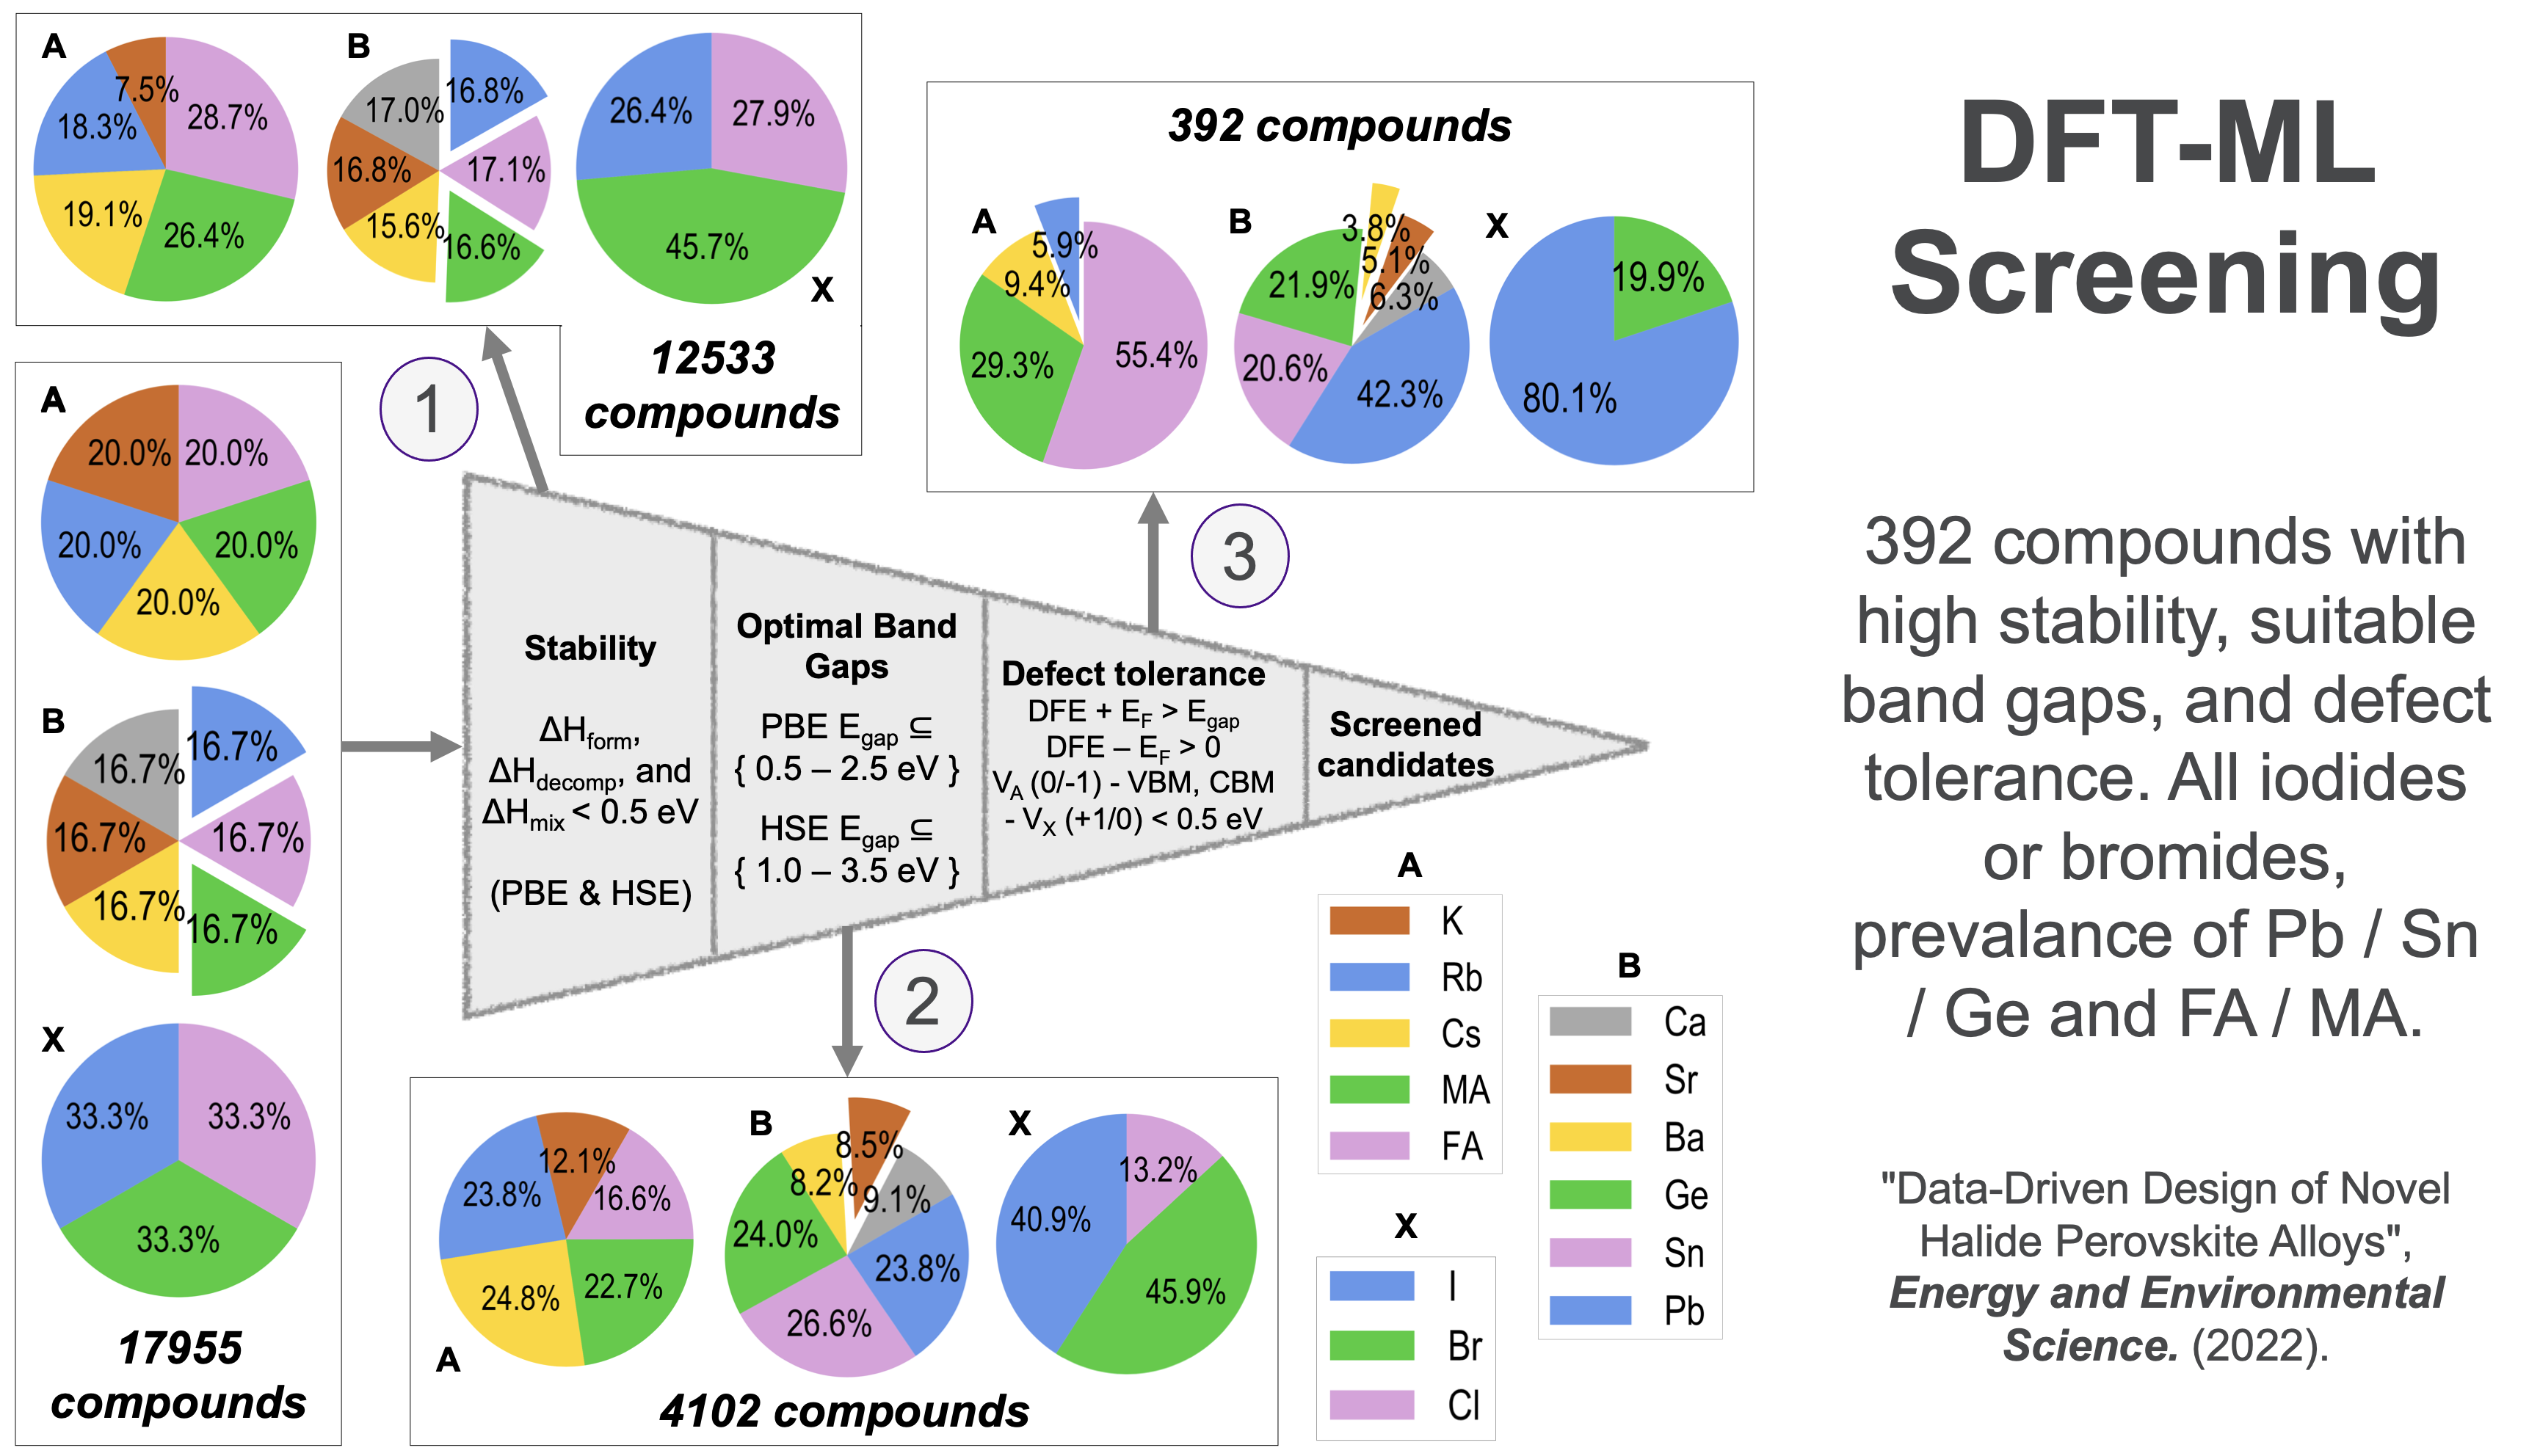

# A more efficient way of discovering novel compositions with desired properties is using a method such as genetic algorithm, wherein perovskite compositions are changed iteratively until multiple property targets are achieved.

In [ ]:
def GA():

    x1 = [0.0]*65
    x2 = [0.0]*65
    for i in range(0,65):
        x1[i] = i/64
#        x2[i] = 3*i/64
        x2[i] = i/64

    varbound = np.array([[0,64], [0,64], [0,64], [0,64], [0,64], [0,64], [0,64], [0,64], [0,64], [0,64], [0,64], [0,64], [0,64], [0,64] ] )
    #varbound = np.array([[0,1], [0,1], [0,1], [0,64], [0,1], [0,1], [0,1], [0,1], [0,64], [0,64], [0,1], [0,1], [0,64], [0,64] ] )
    #atoms = ['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I']


    def f(XX):
        X = [0.0]*14
        for i in range(0,11):
            X[i] = x1[int(XX[i])]
        for i in range(11,14):
            X[i] = x2[int(XX[i])]
        pen = 0
        if np.abs(np.sum(X[0:5]) - 1.0) > 0.0:
            pen = pen + 1000*np.abs(1-np.sum(X[0:5]))
        if np.abs(np.sum(X[5:11]) - 1.0) > 0.0:
            pen = pen + 1000*np.abs(1-np.sum(X[5:11]))
        if np.abs(np.sum(X[11:14]) - 1.0) > 0.0:
            pen = pen + 1000*np.abs(1-np.sum(X[11:14]))
        pred_decomp = float(rfr_decomp.predict( np.reshape(X, (1, -1)) ))
        pred_slme = -1*float(rfr_slme.predict( np.reshape(X, (1, -1)) ))
        pred_gap = float(rfr_gap.predict( np.reshape(X, (1, -1)) ))
        if pred_gap < 1.0:
            pen = pen + 1000*np.abs(pred_gap - 1)
        if pred_gap > 2.0:
            pen = pen + 1000*np.abs(pred_gap - 2.0)
        if pred_decomp > 0.0:
            pen = pen + 1000*np.abs(pred_decomp)
        return pred_slme + pen

    algorithm_param = {'max_num_iteration': 100,
                   'population_size':100,
                   'mutation_probability':0.1,
                   'elit_ratio': 0.01,  
                   'crossover_probability': 0.5,
                   'parents_portion': 0.3,
                   'crossover_type':'uniform',
                   'mutation_type': 'uniform_by_center',
                   'selection_type': 'roulette',
                   'max_iteration_without_improv':None}

    model = ga(function=f, dimension=14, variable_type='int', variable_boundaries=varbound, variable_type_mixed = None, function_timeout = 10, algorithm_parameters=algorithm_param)
    #model.run()

    model.run(
    no_plot = False, 
    disable_progress_bar = False,
    disable_printing = False,

    set_function = None, 
    apply_function_to_parents = False, 
    start_generation = {'variables':None, 'scores': None},
    studEA = False,
    mutation_indexes = None,

    init_creator = None,
    init_oppositors = None,
    duplicates_oppositor = None,
    remove_duplicates_generation_step = None,
    revolution_oppositor = None,
    revolution_after_stagnation_step = None,
    revolution_part = 0.3,

    population_initializer = Population_initializer(select_best_of = 10, local_optimization_step = 'never', local_optimizer = None),

    stop_when_reached = None,
    callbacks = [],
    middle_callbacks = [],
    time_limit_secs = None, 
    seed = None,
    save_last_generation_as = 'last_gen.txt'
    )


    X_best = [0.0]*14
    for i in range(0,11):
        X_best[i] = float( x1[int(model.result.variable[i])] )
    for i in range(11,14):
        X_best[i] = float( x2[int(model.result.variable[i])] )

    print ('best_decomp_energy = ', float ( rfr_decomp.predict( np.reshape(X_best[:], (1,-1)) ) ))
    print ('best_PV_SLME = ', float ( rfr_slme.predict( np.reshape(X_best[:], (1,-1)) ) ))
    print ('best_band_gap = ', float ( rfr_gap.predict( np.reshape(X_best[:], (1,-1)) ) ))

    xx = model.output_dict.get('last_generation')
    sc_frac = str(xx.get('variables')[0])
    zz = xx.get('variables')[0]/64
#    for i in range(11,14):
#        zz[i] = zz[i]*3
    formula_best_perovs = [' ']
    atoms = ['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I']
    for i in range(0,14):
        if float(zz[i]) > 0.004:
            ii = '%.2f' % float(zz[i])
            formula_best_perovs[0] = formula_best_perovs[0] + atoms[i] + '_' + str(ii) + ' '

    print ('best_perovs_alloy = ', formula_best_perovs)
    
    pred_best_prop = "best_decomp_energy = " + str(float(rfr_decomp.predict( np.reshape(X_best[:], (1, -1)) ))) + "  " + "best_PV_SLME = " + str(float(rfr_slme.predict( np.reshape(X_best[:], (1, -1)) ))) + "  " + "best_perovs_alloy = " + str(float(rfr_gap.predict( np.reshape(X_best[:], (1, -1)) )))
    pred_best_compound = formula_best_perovs
    
    return pred_best_prop, pred_best_compound, sc_frac, X_best
    

# text_file = open("results.txt", "w")
# text_file.write("rmse_test_decomp: %s" % np.sqrt( sklearn.metrics.mean_squared_error(Prop_decomp_test_fl, Pred_decomp_test_fl) ) + '\n')
# text_file.write("rmse_train_decomp: %s" % np.sqrt( sklearn.metrics.mean_squared_error(Prop_decomp_train_fl, Pred_decomp_train_fl) ) + '\n')
# text_file.write("rmse_test_slme: %s" % np.sqrt( sklearn.metrics.mean_squared_error(Prop_slme_test_fl, Pred_slme_test_fl) ) + '\n')
# text_file.write("rmse_train_slme: %s" % np.sqrt( sklearn.metrics.mean_squared_error(Prop_slme_train_fl, Pred_slme_train_fl) ) + '\n')
# text_file.write("rmse_test_gap: %s" % np.sqrt( sklearn.metrics.mean_squared_error(Prop_gap_test_fl, Pred_gap_test_fl) ) + '\n')
# text_file.write("rmse_train_gap: %s" % np.sqrt( sklearn.metrics.mean_squared_error(Prop_gap_train_fl, Pred_gap_train_fl) ) + '\n')
# text_file.write(":: %s" % '  ' + '\n')
# text_file.write("best_decomp_energy: %s" % float(rfr_decomp.predict( np.reshape(X_best[:], (1, -1)) )) + '\n')
# text_file.write("best_PV_SLME: %s" % float(rfr_slme.predict( np.reshape(X_best[:], (1, -1)) )) + '\n')
# text_file.write("best_band_gap: %s" % float(rfr_gap.predict( np.reshape(X_best[:], (1, -1)) )) + '\n')
# text_file.write("best_perovs_alloy: %s" % formula_best_perovs + '\n')
# text_file.close()

# np.savetxt('scores.txt', model.report)

# # plot and save optimization process plot
# model.plot_results(save_as = 'plot_scores_process.png')

# # plot scores of last population
# model.plot_generation_scores(title = 'Population scores after ending of searching', save_as= 'plot_scores_end.png')





Average time of function evaluating (secs): 0.054317297220230105 (total = 54.3172972202301)

Best score before optimization: 1832.460791872533
                                                                                                                                                                                                        
 The best found solution:
 [15. 17.  5.  6. 23.  8.  3.  7.  3. 32. 11.  4. 52.  8.]

 Objective function:
 31.12737724260298

 Used generations: 100
 Used time: 413 seconds


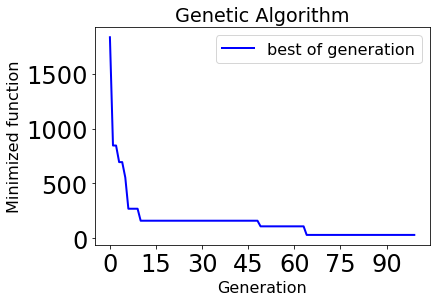

best_decomp_energy =  -0.010760323142803839
best_PV_SLME =  0.12262275739702293
best_band_gap =  1.9943255402422133
best_perovs_alloy =  [' K_0.23 Rb_0.27 Cs_0.08 MA_0.09 FA_0.36 Ca_0.12 Sr_0.05 Ba_0.11 Ge_0.05 Sn_0.50 Pb_0.17 Cl_0.06 Br_0.81 I_0.12 ']

Average time of function evaluating (secs): 0.05180092740058899 (total = 51.80092740058899)

Best score before optimization: 1420.3216806797764
                                                                                                                                                                                                        
 The best found solution:
 [19. 15.  5. 12. 16.  8.  0.  3. 20. 25.  7.  4. 58.  2.]

 Objective function:
 62.346271492193

 Used generations: 100
 Used time: 411 seconds


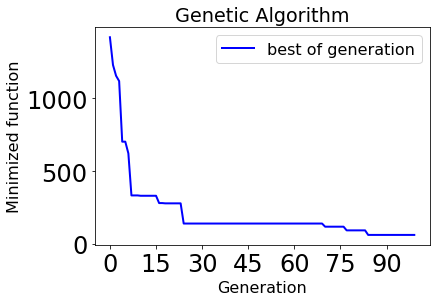

best_decomp_energy =  -0.14139997307477958
best_PV_SLME =  0.1537285078070059
best_band_gap =  1.8391872362281592
best_perovs_alloy =  [' K_0.30 Rb_0.23 Cs_0.08 MA_0.19 FA_0.25 Ca_0.12 Ba_0.05 Ge_0.31 Sn_0.39 Pb_0.11 Cl_0.06 Br_0.91 I_0.03 ']


<BarContainer object of 14 artists>

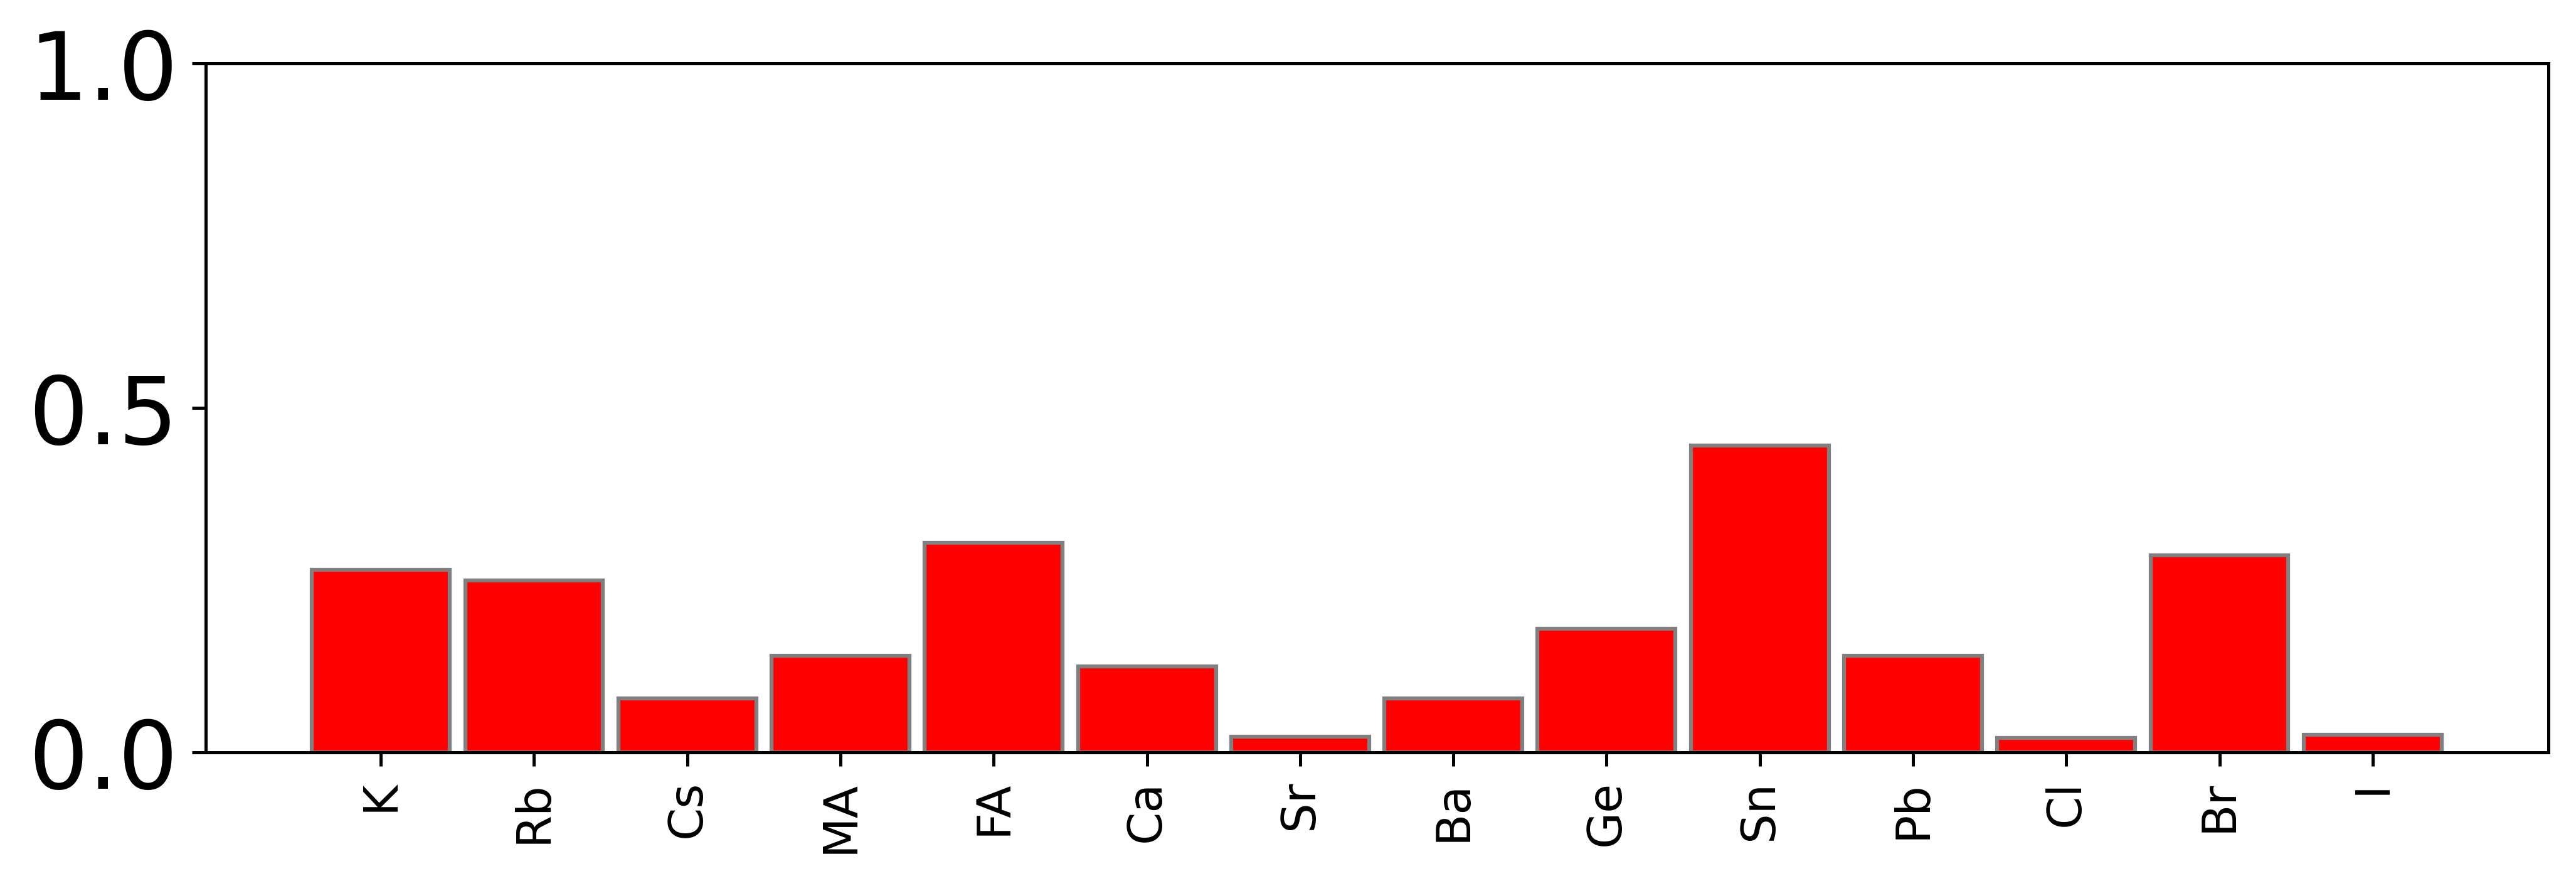

In [ ]:
times = 2

pred_prop = ['s']*times
pred_comp = ['s']*times
sc_frac = ['s']*times
X_b = [0.0]*14
X_best = [[0.0 for a in range(times)] for b in range(14)]

for i in range(0,times):
    pred_prop[i], pred_comp[i], sc_frac[i], X_b = GA()
    for j in range(0,14):
        X_best[j][i] = X_b[j]

text_file = open("pred_prop.txt", "w")
for i in range(0,times):
    text_file.write("Predicted properties: %s" % pred_prop[i] + '\n')
text_file.close()

text_file = open("pred_comp.txt", "w")
for i in range(0,times):
    text_file.write("Compounds: %s" % pred_comp[i] + '\n')
text_file.close()

text_file = open("supercell_fractions.txt", "w")
for i in range(0,times):
    text_file.write("Fractions out of 64: %s" % sc_frac[i] + '\n')
text_file.close()


aa = [0.0]*14
bb = [0.0]*14
for i in range(0,11):
    aa[i] = i
    for j in range(0,times):
        bb[i] = bb[i] + X_best[i][j]
    bb[i] = bb[i]/times
for i in range(11,14):
    aa[i] = i
    for j in range(0,times):
        bb[i] = bb[i] + X_best[i][j]/3
    bb[i] = bb[i]/times
#plt.scatter(aa, bb)


fig=plt.figure(figsize=(10,4),dpi=450)
plt.rcParams.update({'font.size': 16})
plt.rc('font', family='Arial narrow')
plt.subplots_adjust(left=0.21, right=1.04, top=0.85, bottom=0.24, wspace=0.2, hspace=0.2)

ax = plt.plot(plotposition[0])
plt.plot(plotposition[0])
plt.xscale(scale[0])
plt.yscale(scale[0])
#plt.xlim([0,m])
plt.ylim([0,1])

xx = [0.0]*14
for i in range(0,14):
    xx[i] = i
Labels = ['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I']

plt.xticks(xx[:], Labels[:], rotation=90, fontsize=12)
#plt.title('...', fontname='Arial narrow', size=24, horizontalalignment='center', pad=15)
plt.bar(aa, bb, color ='r', width = 0.9, edgecolor ='grey', align='center')

#plt.savefig('GA_fracs.pdf', dpi=450)
